In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install fasttext
!pip install pandas_path
!!pip install pytorch_lightning

     |████████████████████████████████| 68 kB 4.9 MB/s 
  Using cached pybind11-2.9.2-py2.py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3143985 sha256=d58d0eb8edb97f0cd70f63ed702843e487bd6ec77f0ac74fa33c5f2380b9e5a3
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


['Collecting pytorch_lightning',
 '  Downloading pytorch_lightning-1.6.3-py3-none-any.whl (584 kB)',
 '\x1b[?25l',
 '\x1b[K     |▋                               | 10 kB 17.3 MB/s eta 0:00:01',
 '\x1b[K     |█▏                              | 20 kB 21.5 MB/s eta 0:00:01',
 '\x1b[K     |█▊                              | 30 kB 25.8 MB/s eta 0:00:01',
 '\x1b[K     |██▎                             | 40 kB 13.4 MB/s eta 0:00:01',
 '\x1b[K     |██▉                             | 51 kB 11.3 MB/s eta 0:00:01',
 '\x1b[K     |███▍                            | 61 kB 13.0 MB/s eta 0:00:01',
 '\x1b[K     |████                            | 71 kB 11.4 MB/s eta 0:00:01',
 '\x1b[K     |████▌                           | 81 kB 12.3 MB/s eta 0:00:01',
 '\x1b[K     |█████                           | 92 kB 13.5 MB/s eta 0:00:01',
 '\x1b[K     |█████▋                          | 102 kB 12.5 MB/s eta 0:00:01',
 '\x1b[K     |██████▏                         | 112 kB 12.5 MB/s eta 0:00:01',
 '\x1b[K     |██████▊    

In [ ]:
import json
import logging
from pathlib import Path
import random
import tarfile
import tempfile
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_path  # Path style access for pandas
from tqdm import tqdm
import torch                    
import torchvision
import fasttext

In [ ]:
data_dir = Path.cwd().parent / r"/content/drive/MyDrive/Image_Dataset"
img_path = Path.cwd().parent / r"/content/drive/MyDrive/Image_Dataset/Image_Dataset"
dev_path = data_dir / "Image_Datase"
# img_tar_path = data_dir / "img.tar.gz"
train_path = Path.cwd().parent / r"/content/drive/MyDrive/Image_Dataset/eng_1467_.csv"


# test_path = data_dir / "test.jsonl"

In [ ]:
train_samples_frame_1 = pd.read_csv(train_path)
train_samples_frame = train_samples_frame_1[:1000] 
train_samples_frame.head()

,Unnamed: 0,id,Image,Comment,Likes
0,0,0,Image1.png,"The wording ""Rescue"" behind the lifeguard tank...",0
1,1,1,Image2.png,There is an air of engagement,0
2,2,2,Image3.png,Lines expert,0
3,3,3,Image4.png,It happens to me too | 0,0
4,4,4,Image5.png,And we inform you that after the 31st great de...,1


In [ ]:
from PIL import Image


images = [
    Image.open(
        img_path / train_samples_frame.loc[i, "Image"]
    ).convert("RGB")
    for i in range(5)
]

for image in images:
    print(image.size)

(674, 845)
(446, 625)
(1215, 577)
(721, 381)
(533, 670)


In [ ]:
class HatefulMemesDataset(torch.utils.data.Dataset):
    """Uses jsonl data to preprocess and serve 
    dictionary of multimodal tensors for model input.
    """

    def __init__(
        self,
        data_path,
        img_dir,
        image_transform,
        text_transform,
        balance=False,
        dev_limit=None,
        random_state=0,
    ):

        self.samples_frame =  pd.read_csv(
            data_path
        )
        
          
       
        self.dev_limit = dev_limit
        if balance:
            neg = self.samples_frame[
                self.samples_frame.label.eq(0)
            ]
            pos = self.samples_frame[
                self.samples_frame.label.eq(1)
            ]
            self.samples_frame = pd.concat(
                [
                    neg.sample(
                        pos.shape[0], 
                        random_state=random_state
                    ), 
                    pos
                ]
            )
        if self.dev_limit:
            if self.samples_frame.shape[0] > self.dev_limit:
                self.samples_frame = self.samples_frame.sample(
                    dev_limit, random_state=random_state
                )
        self.samples_frame = self.samples_frame.reset_index(
            drop=True
        )
        self.samples_frame.Image = self.samples_frame.apply(
            lambda row: (img_dir / row.Image), axis=1
        )
        # print(self.samples_frame.Image)

        # https://github.com/drivendataorg/pandas-path
        # if not self.samples_frame.img.path.exists().all():
        #     raise FileNotFoundError
        # if not self.samples_frame.img.path.is_file().all():
        #     raise TypeError
            
        self.image_transform = image_transform
        self.text_transform = text_transform

    def __len__(self):
        """This method is called when you do len(instance) 
        for an instance of this class.
        """
        return len(self.samples_frame)

    def __getitem__(self, idx):
        """This method is called when you do instance[key] 
        for an instance of this class.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_id = self.samples_frame.loc[idx, "id"]

        image = Image.open(
            self.samples_frame.loc[idx, "Image"]
        ).convert("RGB")
        image = self.image_transform(image)

        text = torch.Tensor(
            self.text_transform.get_sentence_vector(
                self.samples_frame.loc[idx, "Comment"]
            )
        ).squeeze()
        # print(text.shape)
        # print(image.shape)

        if "Likes" in self.samples_frame.columns:
            label = torch.Tensor(
                [self.samples_frame.loc[idx, "Likes"]]
            ).long().squeeze()
            sample = {
                 "id": img_id, 
                "image": image, 
                "text": text, 
                "label": label
            }
        else:
            sample = {
                 "id": img_id, 
                "image": image, 
                "text": text,
               
            }
  

        return sample


In [ ]:
class LanguageAndVisionConcat(torch.nn.Module):
    def __init__(
        self,
        num_classes,
        loss_fn,
        language_module,
        vision_module,
        language_feature_dim,
        vision_feature_dim,
        fusion_output_size,
        dropout_p,
        
    ):
        super(LanguageAndVisionConcat, self).__init__()
        self.language_module = language_module
        self.vision_module = vision_module
        self.fusion = torch.nn.Linear(
            in_features=(language_feature_dim + vision_feature_dim), 
            out_features=fusion_output_size
        )
        self.fc = torch.nn.Linear(
            in_features=fusion_output_size, 
            out_features=num_classes
        )
        self.loss_fn = loss_fn
        self.dropout = torch.nn.Dropout(dropout_p)
        
    def forward(self, text, image, label=None):

        text_features = torch.nn.functional.relu(
            self.language_module(text)
        )
        image_features = torch.nn.functional.relu(
            self.vision_module(image)
        )
        combined = torch.cat(
            [text_features, image_features], dim=1
        )
        fused = self.dropout(
            torch.nn.functional.relu(
            self.fusion(combined)
            )
        )
        logits = self.fc(fused)
        pred = torch.nn.functional.softmax(logits)
        # print(pred)
        loss = (
            self.loss_fn(pred, label) 
            
            if label is not None else label
        )
        # print(loss)
        # print(float(loss))
        return (pred, loss)

In [ ]:
a = pd.read_csv(train_path)
ts = []
for i in a['Comment']:
      
   ts.append(i+'/n')
with tempfile.TemporaryFile() as ft_training_data:

  ft_path = Path(str(ft_training_data.name))         
  with ft_path.open('w',encoding="utf8") as ft:

 
    for line in ts:
      ft.write(line + "\n")
language_transform = fasttext.train_unsupervised(str(ft_path),
                    model="cbow",
                    dim=300
                )

In [ ]:
import pytorch_lightning as pl


# for the purposes of this post, we'll filter
# much of the lovely logging info from our LightningModule
warnings.filterwarnings("ignore")
logging.getLogger().setLevel(logging.WARNING)


class HatefulMemesModel(pl.LightningModule):
    def __init__(self, hparams):
        for data_key in ["train_path", "dev_path", "img_dir",]:
            # ok, there's one for-loop but it doesn't count
            if data_key not in hparams.keys():
                raise KeyError(
                    f"{data_key} is a required hparam in this model"
                )
     
        super(HatefulMemesModel, self).__init__()
        self.save_hyperparameters = hparams
        #print(self.save_hyperparameters)
        # assign some save_hyperparameters that get used in multiple places
        self.embedding_dim = self.save_hyperparameters.get("embedding_dim", 300)
       
        self.language_feature_dim = self.save_hyperparameters.get(
            "language_feature_dim", 300
        )
        
        self.vision_feature_dim = self.save_hyperparameters.get(
            # balance language and vision features by default
            "vision_feature_dim", self.language_feature_dim
        )
        self.output_path = Path(
            self.save_hyperparameters.get("output_path", "model-outputs")
        )
        
        self.output_path.mkdir(exist_ok=True)
        
        # instantiate transforms, datasets
        self.text_transform = self._build_text_transform()
      
        self.image_transform = self._build_image_transform()
        self.train_dataset = self._build_dataset("train_path")
        #self.dev_dataset = self._build_dataset("dev_path")
        
        # set up model and training
        self.model = self._build_model()
        self.trainer_params = self._get_trainer_params()
    
    ## Required LightningModule Methods (when validating) ##
    
    def forward(self, text, image, label=None):
     
     
      return self.model(text, image, label)

    def training_step(self, batch, batch_nb):
        preds, loss = self.forward(
            text=batch["text"], 
            image=batch["image"], 
            label=batch["label"]
        )
        return {"loss": loss}

    def validation_step(self, batch, batch_nb):
        preds, loss = self.eval().forward(
            text=batch["text"], 
            image=batch["image"], 
            label=batch["label"]
        )
        
        return {"batch_val_loss": loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack(
            tuple(
                output["batch_val_loss"] 
                for output in outputs
            )
        ).mean()
        # print(avg_loss)
        
        return {
            "val_loss": avg_loss,
            "progress_bar":{"avg_val_loss": avg_loss}
        }

    # def configure_optimizers(self):
    #     optimizers = [
    #         torch.optim.AdamW(
    #             self.model.parameters(), 
    #             lr=self.save_hyperparameters.get("lr", 0.001)
    #         )
    #     ]
    #     schedulers = [
    #         torch.optim.lr_scheduler.ReduceLROnPlateau(
    #             optimizers[0]
    #         )
    #     ]
    #     return optimizers, schedulers
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            params=self.parameters(), 
            lr=self.save_hyperparameters.get("lr", 0.001)
           
        )
        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        #     optimizer,
        #     patience=1,
        #     verbose=True
        # )
        return {
           'optimizer': optimizer,
          #  'lr_scheduler': scheduler, # Changed scheduler to lr_scheduler
          #  'monitor': 'val_loss'

       }
    
   
    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset, 
            shuffle=True, 
            batch_size=self.save_hyperparameters.get("batch_size", 1), 
            num_workers=self.save_hyperparameters.get("num_workers", 16)
        )

   
    # def val_dataloader(self):
    #     return torch.utils.data.DataLoader(
    #         self.dev_dataset, 
    #         shuffle=False, 
    #         batch_size=self.save_hyperparameters.get("batch_size", 4), 
    #         num_workers=self.save_hyperparameters.get("num_workers", 16)
    #     )
    
    ## Convenience Methods ##
    
    def fit(self):
        self._set_seed(self.save_hyperparameters.get("random_state", 42))
        self.trainer = pl.Trainer(**self.trainer_params)
        self.trainer.fit(self)
        
    def _set_seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
    def  _build_text_transform(self):
      global language_transform
      return language_transform

    # def _build_text_transform(self,t):


    #      with tempfile.TemporaryFile() as ft_training_data:

    #       ft_path = Path(str(ft_training_data.name))         
    #       with ft_path.open('w',encoding="utf8") as ft:
            # TweetsFile = open(train_path,'r+')
            # training_data = [line.split('/n') for line in ts]
            
              
                
            # training_data = [
            #         json.loads(line)["text"] + "/n" 
            #         for line in open(
            #             self.save_hyperparameters.get("train_path")
            #         ).read().splitlines()
            #     ]
                
            # print(t) 
            # for line in t:
            #   ft.write(line + "\n")
                    
            # print(line)
                    
            # language_transform = fasttext.train_unsupervised(
            #         str(ft_path),
            #         model="cbow",
            #         dim=200
            #     )
      
          # return language_transform
   
              
    def _build_image_transform(self):
        image_dim = self.save_hyperparameters.get("image_dim", 224)
        
        image_transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize(
                    size=(image_dim, image_dim)
                ),        
                torchvision.transforms.ToTensor(),
                # all torchvision models expect the same
                # normalization mean and std
                # https://pytorch.org/docs/stable/torchvision/models.html
                torchvision.transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225)
                ),
            ]
        )
       
        return image_transform

    def _build_dataset(self, dataset_key):
        
        return HatefulMemesDataset(
            data_path=self.save_hyperparameters.get(dataset_key, dataset_key),
            # data_path = train_path,
           
            # data_path = r'C:\Users\Dell\Downloads\hatefull_memes\hateful_memes\train.jsonl',
            #img_dir=self.save_hyperparameters.get("img_dir"),
            img_dir = img_path,
            image_transform=self.image_transform,
            text_transform=self.text_transform,
            # limit training samples only
            # dev_limit=(
            #     self.save_hyperparameters.get("dev_limit", None) 
            #     if "train" in str(dataset_key) else None
            # ),
            # balance=True if "train" in str(dataset_key) else False,
        )
    
  
        
    def _build_model(self):
        # we're going to pass the outputs of our text
        # transform through an additional trainable layer
        # rather than fine-tuning the transform
        language_module = torch.nn.Linear(
                in_features=self.embedding_dim,
                out_features=self.language_feature_dim
        )
        
        # easiest way to get features rather than
        # classification is to overwrite last layer
        # with an identity transformation, we'll reduce
        # dimension using a Linear layer, resnet is 2048 out
        vision_module = torchvision.models.resnet152(
            pretrained=True
        )
        vision_module.fc = torch.nn.Linear(
                in_features=2048,
                out_features=self.vision_feature_dim
        )

        return LanguageAndVisionConcat(
            num_classes=self.save_hyperparameters.get("num_classes", 2),
            loss_fn=torch.nn.CrossEntropyLoss(),
            language_module=language_module,
            vision_module=vision_module,
            language_feature_dim=self.language_feature_dim,
            vision_feature_dim=self.vision_feature_dim,
            fusion_output_size=self.save_hyperparameters.get(
                "fusion_output_size", 512
            ),
            dropout_p=self.save_hyperparameters.get("dropout_p", 0.1),
        )
    
    def _get_trainer_params(self):
        
        checkpoint_callback = pl.callbacks.ModelCheckpoint(
            
            dirpath=self.output_path,
            monitor=self.save_hyperparameters.get(
                "checkpoint_monitor", "val_loss"
            ),
            mode=self.save_hyperparameters.get(
                "checkpoint_monitor_mode", "min"
            ),
            verbose=self.save_hyperparameters.get("verbose", True)
        )

        early_stop_callback = pl.callbacks.EarlyStopping(
            monitor=self.save_hyperparameters.get(
                "early_stop_monitor", "val_loss"
            ),
            min_delta=self.save_hyperparameters.get(
                "early_stop_min_delta", 0.001
            ),
            patience=self.save_hyperparameters.get(
                "early_stop_patience", 3
            ),
            verbose=self.save_hyperparameters.get("verbose", True),
        )

        trainer_params = {
            "checkpoint_callback": checkpoint_callback,
            #"early_stop_callback": early_stop_callback,
            #"default_save_path": self.output_path,
            "accumulate_grad_batches": self.save_hyperparameters.get(
                "accumulate_grad_batches", 1
            ),
            #"gpus": self.save_hyperparameters.get("n_gpu", 1),
            "max_epochs": self.save_hyperparameters.get("max_epochs", 100),
            "gradient_clip_val": self.save_hyperparameters.get(
                "gradient_clip_value", 1
            ),
        }
        return trainer_params
            
    @torch.no_grad()
    def make_submission_frame(self, test_path):
        test_dataset = self._build_dataset(test_path)
        submission_frame = pd.DataFrame(
            index=test_dataset.samples_frame.id,
            columns=["proba", "label"]
        )

        test_dataloader = torch.utils.data.DataLoader(
            test_dataset, 
            shuffle=False, 
            batch_size=self.hparams.get("batch_size", 4), 
            # num_workers=self.hparams.get("num_workers", 16)
            )
        for batch in tqdm(test_dataloader, total=len(test_dataloader)):
            preds, _  = self.model.eval().to("cpu")(
                batch["text"], batch["image"]
            )
        #     print(preds)
        #     print(loss)
        # for batch in tqdm(test_dataloader, total=len(test_dataloader)):
        #     preds, loss = self.model(
        #         batch["text"], batch["image"]
        #     )
            # print(self.model(
            #     batch["text"], batch["image"]
            # ))
            # print(loss)

        
                       
            submission_frame.loc[batch["id"], "proba"] = preds[:, 1]
            submission_frame.loc[batch["id"], "label"] = preds.argmax(dim=1)
            
        submission_frame.proba = submission_frame.proba.astype(float)
        submission_frame.label = submission_frame.label.astype(int)
        return submission_frame


In [ ]:
hparams = {
    
    # Required hparams
    "train_path": train_path,
    "dev_path": dev_path,
    "img_dir": data_dir,
    
    # Optional hparams
    # "embedding_dim": 150,
    # "language_feature_dim": 300,
    # "vision_feature_dim": 300,
    # "fusion_output_size": 256,
    "output_path": "model-outputs",
    # "dev_limit": None,
    # "lr": 0.00005,
    "max_epochs": 2,
    # "n_gpu": 1,
    # "batch_size": 2,
    # allows us to "simulate" having larger batches 
    # "accumulate_grad_batches": 10,
    # "early_stop_patience": 3,
}

hateful_memes_model = HatefulMemesModel(hparams=hparams)
hateful_memes_model.fit()

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/lightning_logs

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | LanguageAndVisionConcat | 59.2 M
--------------------------------------------------
59.2 M    Trainable params
0         Non-trainable params
59.2 M    Total params
236.630   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [ ]:
test_path = Path.cwd().parent / r"/content/drive/MyDrive/test_eng_1467_.csv"

submission = hateful_memes_model.make_submission_frame(
    test_path
)
print(submission)

100%|██████████| 50/50 [01:35<00:00,  1.91s/it]

         proba  label
id                   
1100  0.645499      1
1101  0.636414      1
1102  0.636313      1
1103  0.636940      1
1104  0.637196      1
...        ...    ...
1295  0.634092      1
1296  0.635493      1
1297  0.637181      1
1298  0.637051      1
1299  0.637168      1

[200 rows x 2 columns]


In [ ]:

# for i in submission['label']:
#   print(i)


In [ ]:
test_samples_frame = pd.read_csv(test_path)
y_predicted = submission.label

y_test = test_samples_frame.Likes

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)

Text(33.0, 0.5, 'Truth')

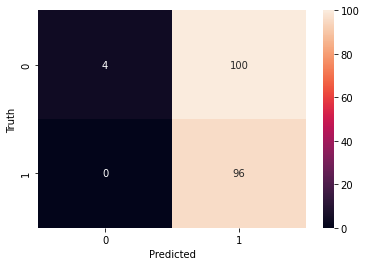

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
y_predicted = submission.label

y_test = test_samples_frame.Likes

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)

ValueError: ignored

In [ ]:
a = 0
for i in submission['proba']:
  print(i)
print(a)

0.4795771837234497
0.4799607992172241
0.4708440601825714
0.4801729917526245
0.47825515270233154
0.48402348160743713
0.48203274607658386
0.4833577573299408
0.4645801782608032
0.4837145507335663
0.48051026463508606
0.47258415818214417
0.4671383500099182
0.4849800765514374
0.4751911759376526
0.4768650233745575
0.4736994504928589
0.47831815481185913
0.48144954442977905
0.4847353398799896
0.48427847027778625
0.4769921898841858
0.4781210124492645
0.4720875322818756
0.48816201090812683
0.48126739263534546
0.47504377365112305
0.47329214215278625
0.4721623957157135
0.47936373949050903
0.47746261954307556
0.482742041349411
0.4784659743309021
0.47958412766456604
0.4808819591999054
0.4815741777420044
0.4743525981903076
0.4715152382850647
0.4893120527267456
0.4815880060195923
0.47946861386299133
0.4768654704093933
0.4803493618965149
0.4777207374572754
0.48540544509887695
0.4766009747982025
0.4734409749507904
0.48198747634887695
0.4690873920917511
0.48764821887016296
0.4808601140975952
0.47486722469

In [ ]:
test_path = Path.cwd().parent / r"/content/drive/MyDrive/test_eng_1467_.csv"
a = pd.read_csv(test_path)
a.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    200 non-null    int64 
 1   Unnamed: 0.1  200 non-null    int64 
 2   id            200 non-null    int64 
 3   Image         200 non-null    object
 4   Comment       200 non-null    object
 5   Likes         200 non-null    int64 
dtypes: int64(4), object(2)
memory usage: 9.5+ KB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
